<div align='center'><font size="5" color='#9ff900'>Image Segmentation for Nuclei Detection</font></div>
<div align='center'><font size="4" color='#ff900'>Using U-Net</font></div>

In [21]:
import tensorflow as tf
import zipfile
import numpy as np
import random
import os
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# # Load the extension and start TensorBoard

# %load_ext tensorboard
# %tensorboard --logdir logs

In [3]:
SEED = 42
np.random.seed = SEED

Setting the path for storing the unzipped dataset. The dataset used is [2018 Data Science Bowl Dataset](https://www.kaggle.com/c/data-science-bowl-2018/overview) from Kaggle. 

In [4]:
UNZIP_PATH = 'input/data-science-bowl-2018/'

Unzipping the dataset using the `ZipFile`

In [5]:
# with zipfile.ZipFile(UNZIP_PATH+'stage1_train.zip', 'r') as zip_ref:
#     zip_ref.extractall('./train')
    
# with zipfile.ZipFile(UNZIP_PATH+'stage1_test.zip', 'r') as zip_ref:
#     zip_ref.extractall('./test')

Setting the path of training and testing dataset

In [5]:
TRAIN_PATH = './train/'
TEST_PATH = './test/'

Defining a resolution for resizing the image as images are of different resolution and size.

In [6]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

Getting list of all the subfolders to keep track of training and testing ID's

In [7]:
train_ids = next(os.walk(TRAIN_PATH))[1] # get list of all subfolders
test_ids = next(os.walk(TEST_PATH))[1]

In [8]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)

Resizing the training and testing images and concatinating all of the masks of the training dataset into a single mask. Each mask contains a single nucleus such that no two pixel coincide with each other. The masks are the concatenated into a single mask which have all of the nuclei present in the pathological image.

In [9]:
# Resize images and masks
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True)
    X_train[n] = img # fill empti X_train with values from img 
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range = True), axis = -1)
        mask = np.maximum(mask, mask_)
    
    Y_train[n] = mask

100%|██████████| 670/670 [08:59<00:00,  1.24it/s] 


In [10]:
# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True)
    X_test[n] = img

100%|██████████| 65/65 [00:01<00:00, 35.56it/s]


Creating a training boolean to control the model learning everytime we run the code. For the first time set `training = True`.

In [38]:
training = False

Creating the U-Net model

In [39]:
if training == True:
    inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    s = tf.keras.layers.Lambda(lambda x: x/255.0)(inputs) # normalization

    # Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(s) # start with normal distributed weights
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c1)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c2)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c3)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c4)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c5)

    # Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides = (2,2), padding = "same")(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding = "same")(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides = (2,2), padding = "same")(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides = (2,2), padding = "same")(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c9)

    outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    # Callbacks
    checkpoiter = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose = 1, save_best_only = True)
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir = 'logs')
            ]        
    results = model.fit(X_train, Y_train, validation_split = 0.1, batch_size = 16, epochs = 25, callbacks = callbacks)
    model.save('model.h5')
else:
    model = tf.keras.models.load_model('model.h5')
    model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [56]:
# testing

idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose = 1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose = 1)
preds_test = model.predict(X_test, verbose = 1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

3/3 [==============================] - 1s 518ms/step


In [12]:
def plot_img_train(input_image, output_image1, output_image2):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    ax[0].imshow(input_image, cmap = 'gray')
    ax[0].set_title('Input Image')
    ax[0].axis('off')
    ax[1].imshow(output_image1, cmap = 'gray')
    ax[1].set_title('Actual')
    ax[1].axis('off')
    ax[2].imshow(output_image2, cmap = 'gray')
    ax[2].set_title('Predicted Training')
    ax[2].axis('off')
    plt.show()

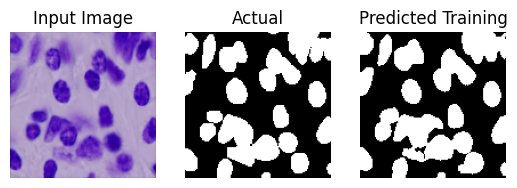

In [46]:
# sanity check on random training samples
ix = random.randint(0, len(preds_train_t))
inp = X_train[ix]
act_out = Y_train[ix]
pred = preds_train_t[ix]
plot_img_train(inp, act_out, pred)

In [19]:
def plot_img_val(input_image, output_image1, output_image2):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    ax[0].imshow(input_image, cmap = 'gray')
    ax[0].set_title('Input Image')
    ax[0].axis('off')
    ax[1].imshow(output_image1, cmap = 'gray')
    ax[1].set_title('Actual')
    ax[1].axis('off')
    ax[2].imshow(output_image2, cmap = 'gray')
    ax[2].set_title('Predicted Validation')
    ax[2].axis('off')
    plt.show()

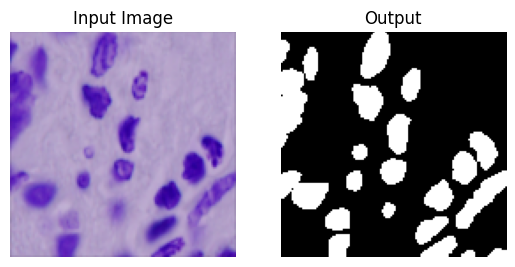

In [44]:
# sanity check on random val samples
ix = random.randint(0, len(preds_val_t))
inp = X_train[int(X_train.shape[0]*0.9):][ix]
out_act = Y_train[int(X_train.shape[0]*0.9):][ix]
pred = preds_val_t[ix]
plot_img_val(inp, out_act, pred)

In [30]:
def plot_img_test(input_image, output_image1):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(input_image, cmap = 'gray')
    ax[0].set_title('test Image')
    ax[0].axis('off')
    ax[1].imshow(output_image1, cmap = 'gray')
    ax[1].set_title('Output')
    ax[1].axis('off')
    plt.show()

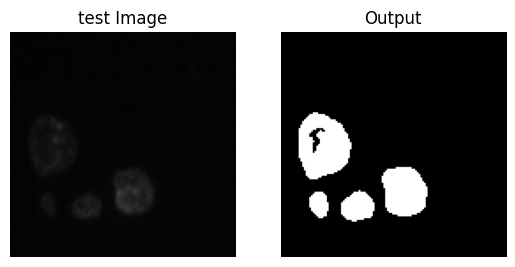

In [37]:
it = random.randint(0, len(preds_test_t))
inp = X_test[it]
op = preds_test_t[it]
plot_img_test(inp, op)

In [ ]:
metrics = ['loss', 'accuracy']

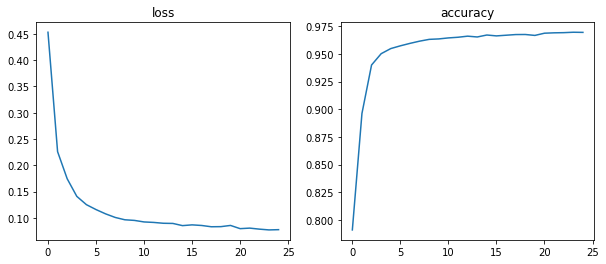

In [ ]:
plt.figure(figsize=(10, 4))
for i in range(len(metrics)):
    metric = metrics[i]
    plt.subplot(1, 2, i+1)
    plt.title(metric) 
    plt_train = results.history[metric] 
    plt.plot(plt_train)
plt.show()

In [ ]:
loss = metrics[0]
train_loss = results.history[loss] 
print("Training Loss: ")
for i in train_loss:
    pass    
print(i)

Training Loss: 
0.07759356498718262


In [ ]:
acc = metrics[1]
train_acc = results.history[acc] 
print("\nTraining Accuracy: ")
for i in train_acc:
    pass
print(i)


Training Accuracy: 
0.9694685339927673
